In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import visuals as vs
import datetime
import csv
import xgboost as xgb
import itertools
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score,mean_squared_error
 

from sklearn.metrics import r2_score,mean_squared_error
from sklearn import grid_search
%matplotlib inline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from matplotlib import pylab as plt
plot = True
goal = 'Sales'
myid = 'Id'
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
def get_data():
    store = pd.read_csv('./store.csv')
    train_org = pd.read_csv('./train.csv',dtype={'StateHoliday':pd.np.string_})
    test_org = pd.read_csv('./test.csv',dtype={'StateHoliday':pd.np.string_})
    train = pd.merge(train_org,store,on='Store',how='left')
    test = pd.merge(test_org,store,on='Store',how='left')
    
    features1 = ['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 
                 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 
                 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
                 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

    feature_non = ['Promo','Store','Date', 'StateHoliday','SchoolHoliday', 'StoreType', 'Assortment', 'Promo2', 'PromoInterval']
    return (train,test,features1,feature_non)

In [5]:
def process_data(train,test,features,features_no): ##数据处理
    train = train[train['Open']==1]
    
    test = test[test['Open']==1]
    for rossm in [train,test]:
        rossm['year'] = rossm.Date.apply(lambda x: int(x.split('-')[0]))
        rossm['month']= rossm.Date.apply(lambda x: int(x.split('-')[1]))
        rossm['day']  = rossm.Date.apply(lambda x: int(x.split('-')[2]))

        rossm['promojan'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jan' in x else 0)
        rossm['promofeb'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Feb' in x else 0)
        rossm['promomar'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Mar' in x else 0)
        rossm['promoapr'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Apr' in x else 0)
        rossm['promomay'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'May' in x else 0)
        rossm['promojun'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jun' in x else 0)
        rossm['promojul'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Jul' in x else 0)
        rossm['promoaug'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Aug' in x else 0)
        rossm['promosep'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Sep' in x else 0)
        rossm['promooct'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Oct' in x else 0)
        rossm['promonov'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Nov' in x else 0)
        rossm['promodec'] = rossm.PromoInterval.apply(lambda x:0 if isinstance(x,float) else 1 if 'Dec' in x else 0)
    
    day_dummies = pd.get_dummies(train['DayOfWeek'],prefix='Day')
    day_dummies.drop(['Day_7'],axis=1,inplace=True)  #删除周日的数据
    train = train.join(day_dummies)

    
    day_dummies_test = pd.get_dummies(test['DayOfWeek'],prefix='Day')
    day_dummies_test.drop(['Day_7'],axis=1,inplace=True)  #删除周日数据
    test = test.join(day_dummies_test)
    
    noisy_features = [myid,'Date']
    features = [c for c in features if c not in noisy_features]
    features_non_numeric = [c for c in features_no if c not in noisy_features]
    features.extend(['year','month','day'])
    class DataFrameInputer(TransformerMixin):
        def __init__(self):
                """
                """
        def fit(self,X,y=None):
            self.fill = pd.Series([X[c].value_counts().index[0] 
                                  if X[c].dtype==np.dtype('O') 
                                   else X[c].mean() for c in X],index = X.columns)
            return self
        def transform(self,X,y=None):
            return X.fillna(self.fill)
        
    train = DataFrameInputer().fit_transform(train)
    test  = DataFrameInputer().fit_transform(test)
        
    le = LabelEncoder()
    for col in features:
        le.fit(list(train[col])+list(test[col]))
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        
    scaler = StandardScaler()
    for col in set(features) - set(features_no) - set([]):
        try:
            scaler.fit(list(train[col])+list(test[col]))
        except:
            print(col)
        train[col] = scaler.transform(train[col])
        test[col] = scaler.transform(test[col])
    return (train,test,features,features_no)

In [6]:
train,test,features,features_non_numeric = get_data()
train,test,features,features_non_numeric = process_data(train,test,features,features_non_numeric)

Open


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [7]:
#1、去除销量中的极值,由于无法估计极值对结果的影响，所以拟合模型的时候可以进行两次，去除极值和未去除极值
#再试一下标准差标准误差
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
store = pd.read_csv('./store.csv')

#2、对时间的拆分
def data_processing(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfYear'] = df['Date'].apply(lambda x: x.dayofyear)
    df['WeekOfYear'] = df['Date'].apply(lambda x: x.week)
    df['Month'] = df['Date'].apply(lambda x: x.month)
    df['DayOfMonth'] = df['Date'].apply(lambda x: x.day)
    df['Year'] = df['Date'].apply(lambda x: x.year)
    return df

#4、为每个日期添加过去一个季度，过去半年，过去一年，过去两年的这家店的平均日销售量
def store_sales_each_day(sale):
    
    def add_mean(store,sale,current_date,past_time):
        past_date = current_date - timedelta(days=past_time)
        mean_sale = sale[(sale['Date'] < current_date) & (sale['Date'] > past_date) & (sale['Store'] == store)]['Sales'].mean()
        return mean_sale
    
    sale['past_quater_mean_sale'] = sale.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 90), axis=1)
    sale['past_year_mean_sale'] = sale.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 183), axis=1)
    
    return sale

#测试集调整
def store_sales_each_day_for_test(sale,test):
    
    def add_mean(store,sale,current_date,past_time):
        past_date = current_date - timedelta(days=past_time)
        mean_sale = sale[(sale['Date'] < current_date) & (sale['Date'] > past_date) & (sale['Store'] == store)]['Sales'].mean()
        return mean_sale
    
    test['past_quater_mean_sale'] = test.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 90), axis=1)
    test['past_year_mean_sale'] = test.apply(lambda row: add_mean(row['Store'], sale, row['Date'], 183), axis=1)

    return test

#3、为每家店添加销售量客流量相关的均值,执行顺序在对时间进行拆分后
def add_mean_for_store(sales,store_df=store) :
    mean_sales_promo = []
    mean_sales_no_promo = []
    mean_sales = []
    mean_sales_2013 = []
    mean_sales_2014 = []
    mean_sales_2015 = []
    mean_store_sales_1month = []
    mean_store_sales_2months = []
    mean_store_sales_3months = []
    mean_store_sales_6months = []
    
    
    mean_customers_promo = []
    mean_customers_no_promo = []
    mean_customers = []
    mean_customers_2013 = []
    mean_customers_2014 = []
    mean_customers_2015 = []
    mean_customers_1month = [] 
    mean_customers_2months = [] 
    mean_customers_3months = []
    mean_customers_6months = []
    
    
    for store in store_df['Store']:
        sale = sales[sales['Store']==store]
        
        # mean of sales
        mean_sales.append(sale['Sales'].mean())
        mean_sales_promo.append(sale[sale['Promo'] == 1]['Sales'].mean())
        mean_sales_no_promo.append(sale[sale['Promo'] == 0]['Sales'].mean())
        mean_sales_2013.append(sale[sale['Year'] == 2013]['Sales'].mean())
        mean_sales_2014.append(sale[sale['Year'] == 2014]['Sales'].mean())
        mean_sales_2015.append(sale[sale['Year'] == 2015]['Sales'].mean())
        mean_store_sales_1month.append(sale[(sale['Month'] == 7) & (sale['Year'] == 2015)]['Sales'].mean())                   
        mean_store_sales_2months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 6) & (sale['Year'] == 2015)]['Sales'].mean())
        mean_store_sales_3months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 5) & (sale['Year'] == 2015)]['Sales'].mean())        
        mean_store_sales_6months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 2) & (sale['Year'] == 2015)]['Sales'].mean())
        
        # mean of customers
        mean_customers.append(sale['Customers'].mean())
        mean_customers_promo.append(sale[sale['Promo'] == 1]['Customers'].mean())
        mean_customers_no_promo.append(sale[sale['Promo'] == 0]['Customers'].mean())
        mean_customers_2013.append(sale[sale['Year'] == 2013]['Customers'].mean())
        mean_customers_2014.append(sale[sale['Year'] == 2014]['Customers'].mean())
        mean_customers_2015.append(sale[sale['Year'] == 2015]['Customers'].mean())
        mean_customers_1month.append(sale[(sale['Month'] == 7) & (sale['Year'] == 2015)]['Customers'].mean())                   
        mean_customers_2months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 6) & (sale['Year'] == 2015)]['Customers'].mean())
        mean_customers_3months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 5) & (sale['Year'] == 2015)]['Customers'].mean())        
        mean_customers_6months.append(sale[(sale['Month'] <= 7) ^(sale['Month'] >= 2) & (sale['Year'] == 2015)]['Customers'].mean())
        
    store_df['mean_sales'] = mean_sales
    store_df['mean_sales_promo'] = mean_sales_promo
    store_df['mean_sales_no_promo'] = mean_sales_no_promo
    store_df['mean_sales_2013'] = mean_sales_2013
    store_df['mean_sales_2014'] = mean_sales_2014
    store_df['mean_sales_2015'] = mean_sales_2015
    store_df['mean_store_sales_1month'] = mean_store_sales_1month
    store_df['mean_store_sales_2months'] = mean_store_sales_2months
    store_df['mean_store_sales_3months'] = mean_store_sales_3months
    store_df['mean_store_sales_6months'] = mean_store_sales_6months
    
    store_df['mean_customers'] = mean_customers
    store_df['mean_customers_promo'] = mean_customers_promo
    store_df['mean_customers_no_promo'] = mean_customers_no_promo
    store_df['mean_customers_2013'] = mean_customers_2013
    store_df['mean_customers_2014'] = mean_customers_2014
    store_df['mean_customers_2015'] = mean_customers_2015
    store_df['mean_customers_1month'] = mean_customers_1month
    store_df['mean_customers_2months'] = mean_customers_2months
    store_df['mean_customers_3months'] = mean_customers_3months
    store_df['mean_customers_6months'] = mean_customers_6months
    
    return store_df

def drop_stores(data_test, data):
	stores = data_test['Store'].unique()         
	return data[data_test['Store'].isin(stores)]

#合并销售和商店 
def merge_sale(sale_data, store_data):
    train = sale_data.join(store_data, on='Store', rsuffix='_')
    train = train.drop('Store_',axis=1)
    return train

#添加其他特征
def extra_features(data):
    data['CompetitionOpen'] = 12 * (data['Year'] - data['CompetitionOpenSinceYear']) + (data['Month'] - data['CompetitionOpenSinceMonth'])
    data['PromoOpen'] = 12 * (data['Year'] - data['Promo2SinceYear'])+ (data['WeekOfYear'] - data['Promo2SinceWeek']) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    data = data.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear'], axis=1) #删除特征
    
    mappings = {'0': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4,'Jan,Apr,Jul,Oct':1,'Feb,May,Aug,Nov':2,'Mar,Jun,Sept,Dec':3}  
    data['StoreType'].replace(mappings, inplace=True)  
    data['Assortment'].replace(mappings, inplace=True)  
    data['StateHoliday'].replace(mappings, inplace=True)
    data['PromoInterval'].replace(mappings, inplace=True)
#     data = data.drop(['Date'],axis= 1)
    return data

#去除极大极小值
# print('Moving outliers')
# train = rm_outliers(train)

#转换年月日
print('Convert Time')
train = data_processing(train)
test = data_processing(test)

#给商店计算平均销售量
store = add_mean_for_store(train)
store = drop_stores(test, store)

print('add additional past_quater_mean_sale and past_year_mean_sale')
#添加额外特征'past_quater_mean_sale'和'past_year_mean_sale'，这段代码运行时间可能会过长
# train = store_sales_each_day(train)
# test = store_sales_each_day_for_test(train,test)

print('Merging')
#合并
train = merge_sale(train, store)
test = merge_sale(test, store)
# train.to_csv('train_withextra.csv',index=False)
# test.to_csv('test_withextra.csv',index=False)

#额外的特征
train = extra_features(train)
test = extra_features(test)

# holidayofyear = sorted(train[train['StateHoliday'].isin([1,2,3,4])]['DayOfYear'].unique())
# def day2holiday(df,holidayofyear):
#     for holiday in holidayofyear:
#         df['DaysToHoliday' + str(holiday)] = holiday - df['DayOfYear']
#     return df

#计算距离节日的日子数
# train = day2holiday(train,holidayofyear)
# test =  day2holiday(test,holidayofyear)

print('Final output')
#生成最终输入


Convert Time
add additional past_quater_mean_sale and past_year_mean_sale
Merging
Final output


In [ ]:
rossm_train = dict(list(train.groupby('Store')))
rossm_test = dict(list(test.groupby('Store')))

In [8]:
a1 = train.columns
a2 = ['Date','Sales','Customers','DayOfWeek']
a1 = [f for f in a1 if f not in a2]

In [9]:

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


# 算法效果对比

In [11]:
train=train.fillna(-1)

In [14]:

y = train['Sales']
x = train[a1]
X_train,X_test,y_train,y_test = cross_validation.train_test_split(x,y,test_size=0.3)

clf_a = LinearRegression()
clf_a.fit(X_train,y_train)
clf_a.predict(X_test)
print('LinearRegression',rmspe(clf_a.predict(X_test),y_test))
clf_b = RandomForestRegressor()
clf_b.fit(X_train,y_train)
print('RandomForestRegressor',rmspe(clf_b.predict(X_test),y_test))
clf_d = tree.DecisionTreeRegressor()
clf_d.fit(X_train,y_train)
print('DecisionTreeRegressor',rmspe(clf_d.predict(X_test),y_test))
clf_e = xgb.XGBRegressor()
clf_e.fit(X_train,y_train)
print('XGboost',rmspe(clf_e.predict(X_test),y_test))

LinearRegression 0.48695183060797914
RandomForestRegressor 0.2777938516882318
DecisionTreeRegressor 0.35059177563694827
XGboost 0.4455036836188242


In [19]:
seed=123
num_round = 3000
X_train, X_test, y_train, y_test = train_test_split(train[a1],train['Sales'],test_size=0.1, random_state=seed)
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
learning_rate = 0.001
param = {   'seed':seed,
            'tree_method':'gpu_hist'}

bst = xgb.train(parm, dtrain, num_round, watchlist, feval=rmspe_xg, verbose_eval=100, early_stopping_rounds=100)

[0]	train-rmse:5.28161	eval-rmse:5.27871	train-rmspe:0.908213	eval-rmspe:0.907822
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[100]	train-rmse:0.181558	eval-rmse:0.181451	train-rmspe:0.24984	eval-rmspe:0.200369
[200]	train-rmse:0.163453	eval-rmse:0.1643	train-rmspe:0.217092	eval-rmspe:0.178964
[300]	train-rmse:0.155343	eval-rmse:0.157656	train-rmspe:0.199501	eval-rmspe:0.17021
[400]	train-rmse:0.1506	eval-rmse:0.154422	train-rmspe:0.19212	eval-rmspe:0.164565
[500]	train-rmse:0.147279	eval-rmse:0.152513	train-rmspe:0.18656	eval-rmspe:0.161988
[600]	train-rmse:0.144694	eval-rmse:0.151443	train-rmspe:0.182884	eval-rmspe:0.160675
[700]	train-rmse:0.142767	eval-rmse:0.150721	train-rmspe:0.179841	eval-rmspe:0.159627
[800]	train-rmse:0.140494	eval-rmse:0.150041	train-rmspe:0.174019	eval-rmspe:0.15857
[900]	train-rmse:0.138779	eval-rmse:0.149659	train-rmspe:0.165701	eval-rmspe:0.157836
[1000]	

### 从单个店数据查看xgboost算法评分最高



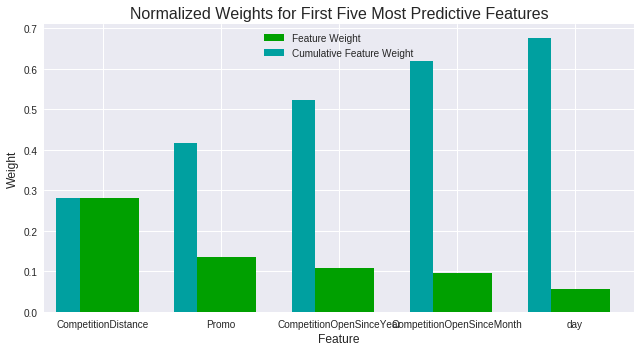

In [72]:
importances = clf_b.feature_importances_
vs.feature_plot(importances, X_train, y_train)  ##特征重要性查看

In [74]:
Linear1 = []
random1 = []
tree1 = []
xgb1 = []

In [63]:
for i in rossm_test:
    store = rossm_train[i]
    y = store['Sales']
    x = store.drop(['Sales','Store','Customers','Date','StateHoliday'],axis=1)
    X_train,X_test,y_train,y_test = cross_validation.train_test_split(x,y,test_size=0.3)

    clf_a = LinearRegression()
    clf_a.fit(X_train,y_train)
    clf_a.predict(X_test)
    Linear1.append(r2_score(clf_a.predict(X_test),y_test))
#     al = al+rmspe(clf_a.predict(X_test),y_test)
    
    clf_b = RandomForestRegressor()
    clf_b.fit(X_train,y_train)
    random1.append(r2_score(clf_b.predict(X_test),y_test))
#     random2.append(round(rmspe(clf_b.predict(X_test),y_test),8))
    clf_d = tree.DecisionTreeRegressor()
    clf_d.fit(X_train,y_train)
    tree1.append(r2_score(clf_d.predict(X_test),y_test))
#     tree2.append(round(rmspe(clf_d.predict(X_test),y_test),8))
    clf_e = xgb.XGBRegressor()
    clf_e.fit(X_train,y_train)
    xgb1.append(r2_score(clf_e.predict(X_test),y_test))
#     xgb2.append(round(rmspe(clf_e.predict(X_test),y_test),8))

In [64]:
print np.mean(Linear1),np.mean(random1),np.mean(tree1),np.mean(xgb1)

0.246445535257 0.580155616319 0.50329742448 0.626765270346


### 从各个店到综合评分可以看出xgboost得分也是最高到

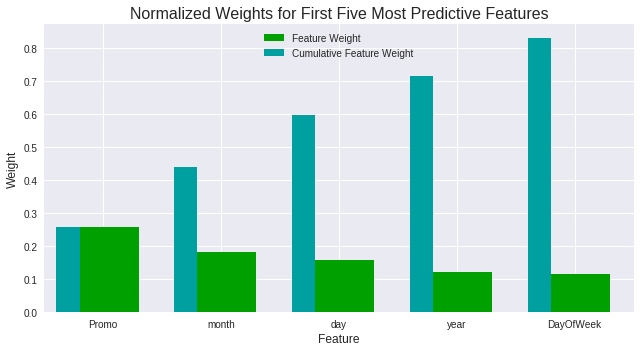

In [65]:
importances = clf_b.feature_importances_
vs.feature_plot(importances, X_train, y_train)

In [83]:
x.columns

Index([u'Open', u'Promo', u'SchoolHoliday', u'StoreType', u'Assortment',
       u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval', u'year', u'month', u'day',
       u'promojan', u'promofeb', u'promomar', u'promoapr', u'promomay',
       u'promojun', u'promojul', u'promoaug', u'promosep', u'promooct',
       u'promonov', u'promodec', u'Day_1', u'Day_2', u'Day_3', u'Day_4',
       u'Day_5', u'Day_6'],
      dtype='object')

In [84]:
store = train
y = store['Sales']
x = store.drop(['Sales','Store','Customers','Date','StateHoliday','DayOfWeek','PromoInterval'],axis=1)
X_train,X_test,y_train,y_test = cross_validation.train_test_split(x,y,test_size=0.3)

clf_a = LinearRegression()
clf_a.fit(X_train,y_train)
clf_a.predict(X_test)
print('LinearRegression',r2_score(clf_a.predict(X_test),y_test))
clf_b = RandomForestRegressor()
clf_b.fit(X_train,y_train)
print('RandomForestRegressor',r2_score(clf_b.predict(X_test),y_test))
clf_d = tree.DecisionTreeRegressor()
clf_d.fit(X_train,y_train)
print('DecisionTreeRegressor',r2_score(clf_d.predict(X_test),y_test))
clf_e = xgb.XGBRegressor()
clf_e.fit(X_train,y_train)
print('XGboost',r2_score(clf_e.predict(X_test),y_test))

('LinearRegression', -2.6091204389900047)
('RandomForestRegressor', 0.87969411370509409)
('DecisionTreeRegressor', 0.81536821084488542)
('XGboost', -1.3463269129403068)


### 根据对比评分结果发现RandomForestRegressor模型效果最好

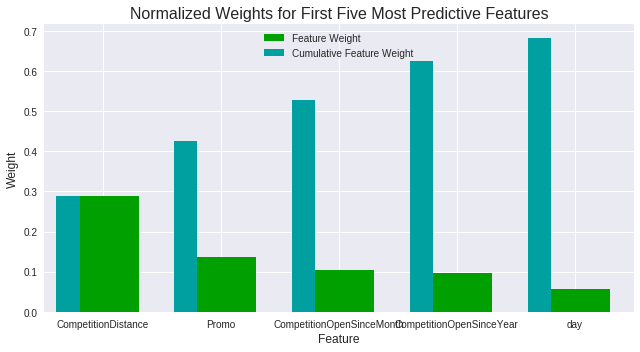

In [86]:
importances = clf_b.feature_importances_
vs.feature_plot(importances, X_train, y_train)

### 最终选择xgboost和RandomForestRegressor两个算法进行最终选择